In [37]:
import os
import sys
sys.path.append("../")
import tensorflow as tf
from glob import glob
from typing import List, Tuple
#from .data_processing.data_loader import dataset_loader
#from rosbag2numpy.data_processing.data_loader_costmap  import dataset_loader
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from typing import Dict, List, Union
from rosbag2numpy.config import params
from rosbag2numpy.config import generalization_model_params as g_params
from data_loader_fv import dataset_loader
import time
import os

print(tf.__version__)


2.4.1


In [46]:
ds_loader = dataset_loader(
    tfrec_dir=r'D:\tf_records_w_cm_fv_diff',
    batch_size=32,
    shuffle_buffer=3200,
    normalize_coords=True,
    normalize_factor=1536.0
)
ds_train, ds_valid, ds_test, ds_test_all = ds_loader.build_scenario_dataset(no_train_scene=11,no_valid_scene=1,no_test_scene=1)

Scenarios:['D:\\tf_records_w_cm_fv_diff\\scenario1', 'D:\\tf_records_w_cm_fv_diff\\scenario2', 'D:\\tf_records_w_cm_fv_diff\\scenario3', 'D:\\tf_records_w_cm_fv_diff\\scenario4', 'D:\\tf_records_w_cm_fv_diff\\scenario5', 'D:\\tf_records_w_cm_fv_diff\\scenario6', 'D:\\tf_records_w_cm_fv_diff\\scenario7', 'D:\\tf_records_w_cm_fv_diff\\scenario8', 'D:\\tf_records_w_cm_fv_diff\\scenario_ph_11', 'D:\\tf_records_w_cm_fv_diff\\scenario_ph_12', 'D:\\tf_records_w_cm_fv_diff\\scenario_ph_13', 'D:\\tf_records_w_cm_fv_diff\\scenario_ph_14', 'D:\\tf_records_w_cm_fv_diff\\scenario_ph_15']
Test scenario:['D:\\tf_records_w_cm_fv_diff\\scenario_ph_12']
Building Dataset.......

Number of records, Train files:948, validation files:98, Test Files:39 

train,valid,test: (TensorSpec(shape=(None, 25, 1040), dtype=tf.float32, name=None), TensorSpec(shape=(None, 25, 2), dtype=tf.float32, name=None))
Test set with all data: ((TensorSpec(shape=(None, 25, 1040), dtype=tf.float32, name=None), TensorSpec(shape=(Non

In [39]:
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf

def _get_optimizer(opt_name: str = "nadam", lr: float = 0.02):
    if opt_name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif opt_name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr)
    elif opt_name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif opt_name == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    elif opt_name == "adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=lr)
    elif opt_name == "adamax":
        return tf.keras.optimizers.Adamax(learning_rate=lr)
    elif opt_name == "nadam":
        return tf.keras.optimizers.Nadam(learning_rate=lr)
    else:
        return tf.keras.optimizers.Nadam(learning_rate=lr)


def net():
    ip_fv = layers.Input(shape=(25,1040))

    x_A = layers.LSTM(units=50)(ip_fv)

    x_A = layers.Reshape(target_shape=(25,2))(x_A)

    nn_fun = models.Model(inputs = ip_fv, outputs= x_A)

    nn_fun.summary()

    return nn_fun

LSTM_model = net()

LSTM_model.compile(
    optimizer=_get_optimizer(opt_name='rms'), 
    loss='mae', metrics='mse')

# Learning rate scheduler
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25, 1040)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                218200    
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 2)             0         
Total params: 218,200
Trainable params: 218,200
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = LSTM_model.fit(ds_train,epochs=20,validation_data=ds_valid, 
                            callbacks=[cb_reduce_lr])

Epoch 1/20
423/423 [==============================] - 106s 194ms/step - loss: 0.0043 - mse: 2.6404e-04 - val_loss: 5.6690e-04 - val_mse: 1.8717e-06
Epoch 2/20
423/423 [==============================] - 103s 191ms/step - loss: 2.3466e-04 - mse: 4.5317e-07 - val_loss: 2.9855e-04 - val_mse: 9.2729e-07
Epoch 3/20
423/423 [==============================] - 102s 191ms/step - loss: 1.5838e-04 - mse: 4.0663e-07 - val_loss: 2.5380e-04 - val_mse: 7.8199e-07
Epoch 4/20
423/423 [==============================] - 103s 192ms/step - loss: 1.3973e-04 - mse: 5.0441e-07 - val_loss: 2.0641e-04 - val_mse: 7.1974e-07
Epoch 5/20
423/423 [==============================] - 103s 192ms/step - loss: 1.3222e-04 - mse: 4.2530e-07 - val_loss: 1.9376e-04 - val_mse: 6.9892e-07
Epoch 6/20
423/423 [==============================] - 103s 192ms/step - loss: 1.3087e-04 - mse: 5.8062e-07 - val_loss: 1.8332e-04 - val_mse: 6.8200e-07
Epoch 7/20
423/423 [==============================] - 103s 192ms/step - loss: 1.2371e-04 - m

In [41]:
test_loss,test_acc = LSTM_model.evaluate(ds_test)

64/64 [==============================] - 14s 211ms/step - loss: 6.3355e-05 - mse: 8.8076e-08


## Evaluation

In [44]:
def _get_test_ds_size(ds_test) -> int:
    """get the size of test dataset

    Args:
        ds_test (tf.data.Dataset): [description]

    Returns:
        [int]: [Number of Samples inside dataset]
    """
    num_of_samples = 0
    # Looping through all batches in test dataset
    for input_batch, output_batch in ds_test:
        # Looping through all samples for a single (current) batch
        #print(input_batch[0].numpy().shape)
        for i in range(0, len(input_batch[0].numpy())):
            num_of_samples += 1
    return num_of_samples


def get_np_test_ds(ds_test) -> Dict[str, Union[ndarray, List]]:
    """Test dataset (in tf.data.Dataset build) to numpy arrays

    Args:
        ds_test ([type]): tf.data.Dataset

    Returns:
        Dict[str,Union[ndarray,List]]: dictionary of feature_vector,costmap,init_path,opt_path,car_odo,file_details,unequal_indices, diff_path
    """
    samples = _get_test_ds_size(ds_test)
    np_tst_feature_vector = np.zeros(shape=(samples,25,1040))
    np_tst_costmap = np.zeros(shape=(samples, 1536, 1536)).astype(np.float16)
    
    #np_tst_left_bnd = np.zeros(shape=(samples, 25, 2))
    #np_tst_right_bnd = np.zeros(shape=(samples, 25, 2))
    np_tst_car_odo = np.zeros(shape=(samples, 2))
    np_tst_init_path = np.zeros(shape=(samples, 25, 2))
    np_tst_opt_path = np.zeros(shape=(samples, 25, 2))
    list_tst_file_details = []

    #list_unequal_indices = []

    #output
    np_tst_diff_path = np.zeros(shape=(samples, 25, 2))

    j = 0
    for input_batch, output_batch in ds_test:

        for i in range(len(input_batch[0].numpy())):
            np_tst_feature_vector[j] = input_batch[0][i].numpy()
            np_tst_costmap[j] = input_batch[1][i].numpy().astype(np.float16)
            #np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            #np_tst_left_bnd[j] = input_batch[2][i].numpy()
            #np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_init_path[j] = input_batch[2][i].numpy()
            np_tst_opt_path[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            list_tst_file_details.append(input_batch[5][i])
            #list_unequal_indices.append(input_batch[6][i])

            #np_tst_opt_path[j] = output_batch[i].numpy()
            np_tst_diff_path[j] = output_batch[i].numpy()
            j = j + 1

    np_ds_test = {
        "feature_vector": np_tst_feature_vector,
        "cost_map": np_tst_costmap,
        #"grid_org_res": np_tst_grid_org_res,
        #"left_bnd": np_tst_left_bnd,
        #"right_bnd": np_tst_right_bnd,
        "init_path": np_tst_init_path,
        "opt_path": np_tst_opt_path,
        "car_odo": np_tst_car_odo,
        "file_details": list_tst_file_details,
        #"unequal_indices": list_unequal_indices,
        "diff_path": np_tst_diff_path,

    }

    # np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path
    return np_ds_test


In [47]:
np_test_ds_all = get_np_test_ds(ds_test=ds_test_all)

In [48]:
cost_map = np_test_ds_all["cost_map"]
feature_v = np_test_ds_all["feature_vector"]
init_path = np_test_ds_all["init_path"]
opt_path = np_test_ds_all["opt_path"]
car_odo = np_test_ds_all["car_odo"]

In [49]:
feature_v.shape

(579, 25, 1040)

In [50]:
predictions = LSTM_model.predict(feature_v)
predicted_paths = init_path - predictions
predicted_paths.shape

(579, 25, 2)

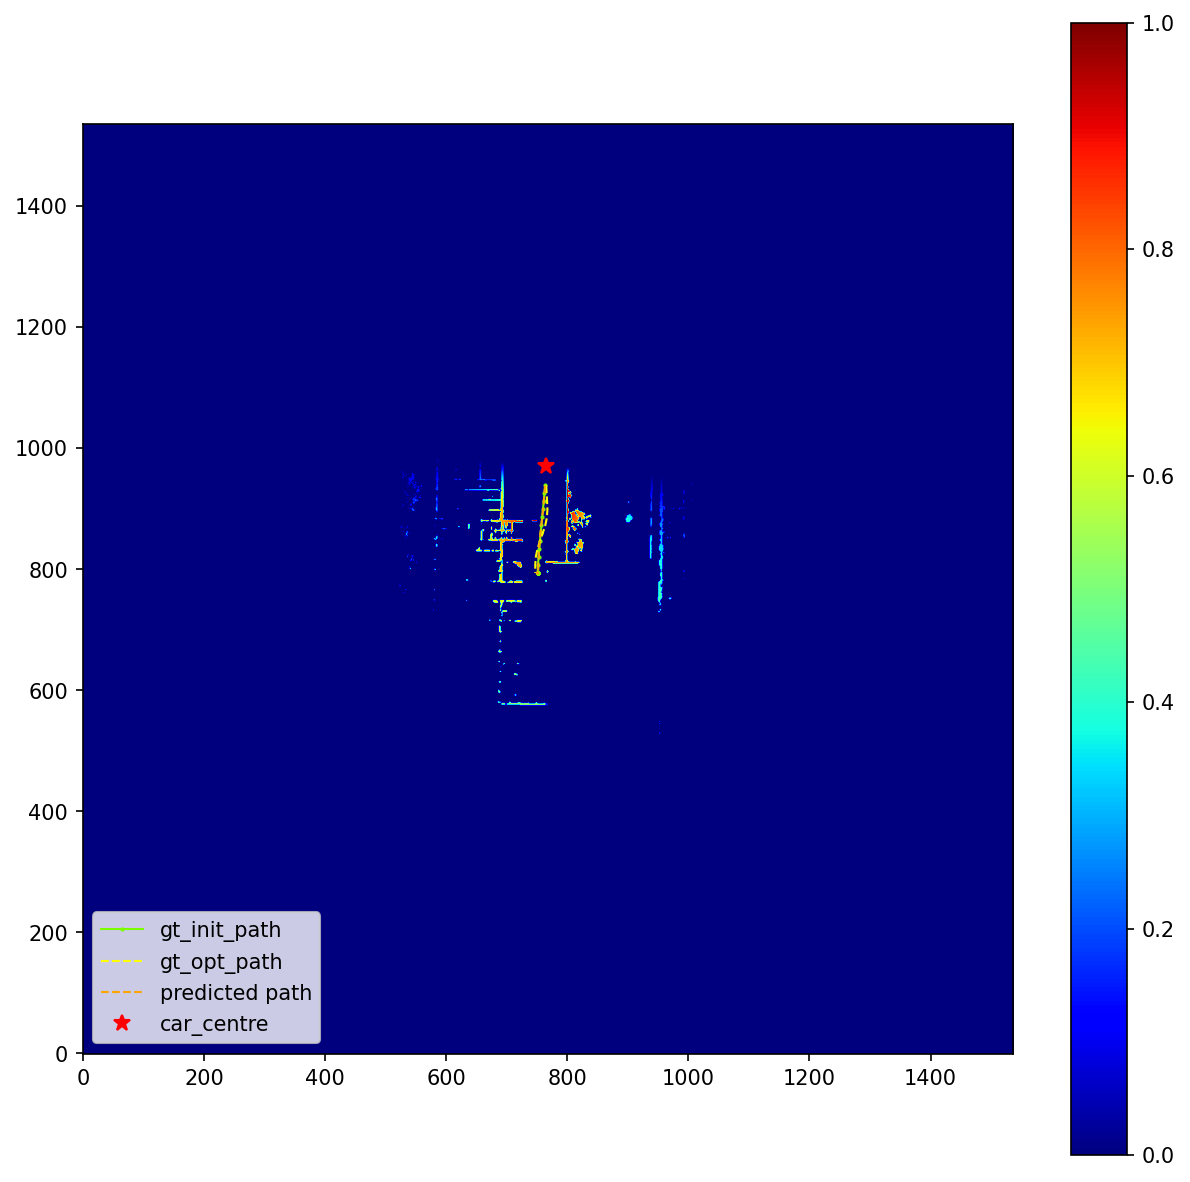

In [55]:
idx=0
normalized_factor=1536
plt.figure(figsize=(10,10),dpi=150)
plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='jet')
plt.colorbar()
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)

plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)

plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "r*",
    color="red",
    markersize=8,
)
plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')

In [16]:
def plot_scene(features,normalized_coords:bool=True,normalized_factor = 1,idx = 1):    
    cost_map = features["cost_map"][idx].astype(float)
    #grid_org = features["grid_org_res"] #[x,y,resolution]
    #left_bnd = features["left_bnd"]
    #right_bnd = features["right_bnd"]
    init_path = features["init_path"][idx].astype(float)
    opt_path = features["opt_path"][idx].astype(float)
    car_odo = features["car_odo"][idx].astype(float)

    #predict_path = features["predictions"]
    file_details=features["file_details"]

    #print(type(grid_map))
    
    plt.figure(figsize=(10, 10))
    #ax=fig.add_subplot(1,1,1)
    if normalized_coords:
            plt.plot(
                init_path[:, 0]*normalized_factor,
                init_path[:, 1]*normalized_factor,
                "o-",
                color="lawngreen",
                markersize=1,
                linewidth=1,
            )
            plt.plot(
                opt_path[:, 0]*normalized_factor,
                opt_path[:, 1]*normalized_factor,
                "--",
                color="yellow",
                markersize=1,
                linewidth=1,
            )

            plt.plot(
                car_odo[0]*normalized_factor,
                car_odo[1]*normalized_factor,
                "r*",
                color="red",
                markersize=8,
            )

            """
            plt.plot(
                predict_path[:, 0]*normalized_factor,
                predict_path[:, 1]*normalized_factor,
                "--",
                color="orange",
                markersize=1,
                linewidth=1,
            )
            """
 

    #plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','predicted_path','right bound', 'car_centre'], loc='lower left')

    #plt.imshow(cost_map,origin="lower",cmap='jet')

    

    plt.title(f"{file_details}\nTest Index: {idx}")

In [ ]:
plot_scene(features=np_test_ds_all,normalized_coords=True,normalized_factor=1,idx=1)